In [ ]:
import pandas as pd
import numpy as np
import torch
import torchvision
from torchsummary import summary
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold, train_test_split
from torch import optim
from torchvision import datasets, transforms, models
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import os
import cv2
import time
import datetime
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
!pip install efficientnet_pytorch
import zipfile
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

In [ ]:
with zipfile.ZipFile("/content/drive/MyDrive/melanoma_256.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

In [ ]:
with zipfile.ZipFile("/content/drive/MyDrive/melanoma_external_256.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

In [ ]:
with zipfile.ZipFile("/content/drive/MyDrive/x_train_32.npy.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

## Exploratory Data Analysis

In [ ]:
train_df = pd.read_csv("/content/archive-2/train.csv")
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000


In [ ]:
train_df.shape

(33126, 11)

### Count Plot of the Target Variables.
We can visualize the imbalance in the dataset.

0    98.237034
1     1.762966
Name: target, dtype: float64

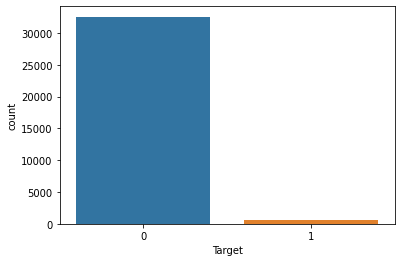

In [ ]:
#sns.set(style="darkgrid")
ax = sns.countplot(x="target", data=train_df)
plt.xlabel("Target")
train_df["target"].value_counts()/len(train_df)*100

### Anatomy vs Target Variable
Head/neck and oral/genital areas are common sites for sampling the data.

Text(0, 0.5, 'Anatomy Site')

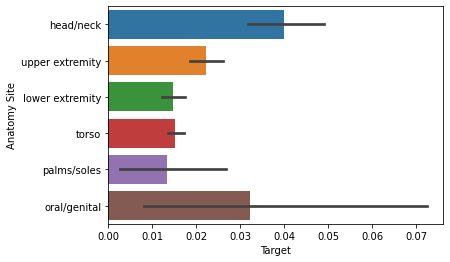

In [ ]:
#sns.set(style="darkgrid")
ax = sns.barplot(x="target", y="anatom_site_general_challenge", data=train_df)
plt.xlabel("Target")
plt.ylabel("Anatomy Site")

In [ ]:
#number of unique patients
len(train_df["patient_id"].unique())

2056

### Benign vs Malignant Count Plot
Males have a high malignant count than females in this dataset.

Text(0.5, 20.799999999999983, 'Benign vs Malignant')

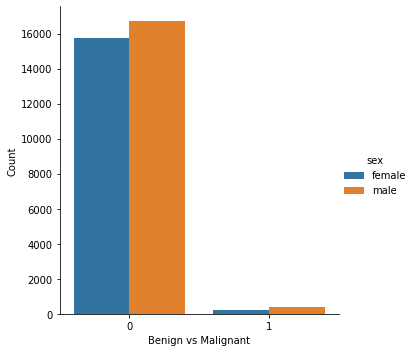

In [ ]:
sex_df = train_df.groupby(['target','sex'])['benign_malignant'].count().to_frame().reset_index()
sns.catplot(x='target',y='benign_malignant', hue='sex',data=sex_df,kind='bar')
plt.ylabel('Count')
plt.xlabel('Benign vs Malignant')

In [ ]:
with_disease = train_df[train_df["target"]==1]
with_disease.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
91,ISIC_0149568,IP_0962375,female,55.0,upper extremity,melanoma,malignant,1,0,6000,4000
235,ISIC_0188432,IP_0135517,female,50.0,upper extremity,melanoma,malignant,1,5,3264,2448
314,ISIC_0207268,IP_7735373,male,55.0,torso,melanoma,malignant,1,3,6000,4000
399,ISIC_0232101,IP_8349964,male,65.0,torso,melanoma,malignant,1,9,4288,2848
459,ISIC_0247330,IP_3232631,female,65.0,lower extremity,melanoma,malignant,1,10,6000,4000


In [ ]:
with_disease.shape

(584, 11)

In [ ]:
print(with_disease.shape)
len(with_disease["patient_id"].unique())

(584, 11)


428

### Age Distribution of People with Melanoma

Text(0.5, 0, 'Age')

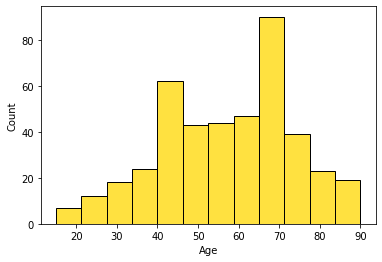

In [ ]:
sns.histplot(with_disease.drop_duplicates(subset=['patient_id'])["age_approx"],color="gold")
plt.xlabel("Age")

In [ ]:
#People without disease
without_disease = [x for x in train_df["patient_id"].unique()  if x not in with_disease["patient_id"].unique()]
print(len(without_disease))

1628


In [ ]:
#Display images of Target label
def display_images(df):
  img_path = "/content/archive-2/train"
  fig=plt.figure(figsize=(6,6))
  columns = 2
  rows = 2
  for i in range(1, columns*rows +1):
      img = cv2.imread(img_path + '/' + df.iloc[i-1][0] + ".jpg")
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      fig.add_subplot(rows, columns, i)
      plt.title(df.iloc[i-1][6])
      plt.imshow(img)
  plt.show()

Malignant

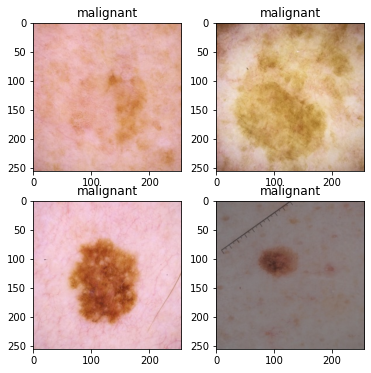

In [ ]:
display_images(train_df[train_df["target"] == 1])

Benign

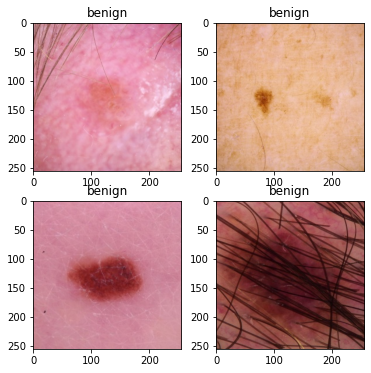

In [ ]:
display_images(train_df[train_df["target"] == 0])

# SVM and Logistic Regression
Taking an image size of 32*32 stored in npy file for the classification with SVM and Logistic Regression.

In [ ]:
x_train_32 = np.load('/content/x_train_32.npy')
x_train_32.shape

(33126, 32, 32, 3)

In [ ]:
x_train_32 = x_train_32.reshape((x_train_32.shape[0], 32*32*3))
x_train_32.shape

(33126, 3072)

In [ ]:
y = train_df.target.values
y.shape

(33126,)

In [ ]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(x_train_32,y,stratify = y,test_size=.1,random_state=42)

### PCA
Principal component analysis capturing 99% variance in the data.

In [ ]:
pca = PCA(n_components=0.99,whiten=True)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
print(X_train.shape)
print(X_test.shape)

(29813, 296)
(3313, 296)


In [ ]:
#Performing 5-Fold Cross Validation for Logistic Regression
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
train_split = np.zeros((X_train.shape[0],))
test_preds = 0
train_split.shape

(29813,)

In [ ]:
avg_auc = []
for fold, (train_index, val_index) in enumerate(kf.split(X_train)):
    print("For Fold", fold+1)
    train_features = X_train[train_index]
    train_target = y_train[train_index]
    val_features = X_train[val_index]
    val_target = y_train[val_index]
    model = LogisticRegression(C=1, solver='lbfgs', multi_class='multinomial', max_iter=64)
    model.fit(train_features, train_target)
    val_pred = model.predict_proba(val_features)[:,1]
    train_split[val_index] = val_pred
    print("Fold AUC:", roc_auc_score(val_target, val_pred))
    avg_auc.append(roc_auc_score(val_target, val_pred))
    print("-"*40)
    test_preds += model.predict_proba(X_test)[:,1]/n_splits
    del train_features, train_target, val_features, val_target
print("Average K-fold AUC:", np.mean(avg_auc))

For Fold 1
Fold AUC: 0.7677388156886777
----------------------------------------
For Fold 2
Fold AUC: 0.8169617454356273
----------------------------------------
For Fold 3
Fold AUC: 0.8286637669185722
----------------------------------------
For Fold 4
Fold AUC: 0.7690233713651982
----------------------------------------
For Fold 5
Fold AUC: 0.798058096261689
----------------------------------------
Average K-fold AUC: 0.796089159133953


In [ ]:
roc_auc_score(y_test, test_preds)

0.815334498649293

In [ ]:
logistic_pred = model.predict(X_test)
print(classification_report(y_test,logistic_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3255
           1       0.29      0.03      0.06        58

    accuracy                           0.98      3313
   macro avg       0.63      0.52      0.53      3313
weighted avg       0.97      0.98      0.97      3313



### SVM using radial basis function kernel

In [ ]:
%%time
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
test_pred = model.predict_proba(X_test)[:,1]

CPU times: user 23min 5s, sys: 2.81 s, total: 23min 8s
Wall time: 22min 59s


In [ ]:
roc_auc_score(y_test, test_pred)

0.7939350601197097

In [ ]:
svm_pred = model.predict(X_test)
print(classification_report(y_test,svm_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3255
           1       0.29      0.03      0.06        58

    accuracy                           0.98      3313
   macro avg       0.63      0.52      0.53      3313
weighted avg       0.97      0.98      0.97      3313



# Deep Learning Based Methods
We have used a Custom CNN Network and a pretrained EfficientNet-B2 model. There are two methods that we used to tackle imbalance; undersampling and oversampling.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

cuda


In [ ]:
class MelanomaDataset(Dataset):
    def __init__(self, df: pd.DataFrame, img_dir: str, train: bool = True, transforms = None):
        self.df = df
        self.img_dir = img_dir 
        self.transforms = transforms
        self.train = train
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_path = os.path.join(self.img_dir, self.df.iloc[index]['image_name'] + '.jpg')
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(img)
        if self.transforms:
            img = self.transforms(img)
        if self.train:
            y = self.df.iloc[index]['target']
            return torch.tensor(img, dtype=torch.float32),torch.tensor(y, dtype=torch.float32)
        else:
            return torch.tensor(img, dtype=torch.float32)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 32, 5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)                        
        self.conv3 = nn.Conv2d(32, 64, 5,padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(64, 128, 3,padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv5 = nn.Conv2d(128, 256, 3,padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(in_features = 8*8*324, out_features= 64)
        self.fc2 = nn.Linear(64, 1)
        self.BatchNorm1 = nn.BatchNorm2d(32)
        self.BatchNorm2 = nn.BatchNorm2d(32)
        self.BatchNorm3 = nn.BatchNorm2d(64)
        self.BatchNorm5 = nn.BatchNorm2d(128)
        self.BatchNorm6 = nn.BatchNorm2d(256)
        self.BatchNorm4 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout2d(p=0.5)  #0.1


    def forward(self, x):

        x = self.conv1(x)
        x = self.BatchNorm1(x)
        x = self.pool(F.relu(x))
        x = self.conv2(x)
        x = self.BatchNorm2(x)
        x = self.pool(F.relu(x))
        x = self.conv3(x)
        x = self.BatchNorm3(x)
        x = self.pool(F.relu(x))
        x = self.conv4(x)
        x = self.BatchNorm5(x)
        x = self.pool(F.relu(x))
        x = self.conv5(x)
        x = self.BatchNorm6(x)
        x = self.pool(F.relu(x))
        x = self.dropout(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        x = self.BatchNorm4(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
class TransferNet(nn.Module):
    def __init__(self, architecture):
        super(TransferNet, self).__init__()
        self.arch = architecture
        if 'EfficientNet' in str(arch.__class__):   
            self.arch._fc = nn.Linear(in_features=1408, out_features=500, bias=True)
            self.dropout1 = nn.Dropout(0.25)
            
        self.output = nn.Linear(500, 1)
        
    def forward(self, images):
        """
        Since BCEWithLogitsLoss uses Sigmoid we don't use sigmoid in forward propagation.
        """
        x = images
        features = self.arch(x)
        features = self.dropout1(features)
        output = self.output(features)
        
        return output

In [ ]:
def get_transforms(mean,std,train=False,minority=False,val=False,test=False):
    
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees= [-10,10]),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ColorJitter(brightness=[0.8,1.2], contrast=[0.8,1.2], saturation=[0.8,1.2]),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,std=std)
    ])
    val_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,std=std)
    ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean,std=std)
    ])
    if train == True:
        return train_transform
    if val == True:
        return val_transform
    if test == True:
        return test_transform
    if minority == True:
        return minority_transform

In [ ]:
def training(model,train_loader,valid_loader,train_df,validation_df,model_path,epochs,es_patience,criterion,optimizer,scheduler,best_score):
    training_loss_history=[]  
    training_accuracy_history=[]  
    validation_loss_history=[]  
    validation_accuracy_history=[] 


    patience = es_patience
    Total_start_time = time.time()  
    model.to(device)

    for epoch in range(epochs):

        start_time = time.time()
        correct = 0
        running_loss = 0
        model.train()

        for images, labels in train_loader:


            images, labels = images.to(device), labels.to(device)


            optimizer.zero_grad()

            output = model(images) 
            loss = criterion(output, labels.view(-1,1))  
            loss.backward()
            optimizer.step()

            # Training loss
            running_loss += loss.item()

            # Number of correct training predictions and training accuracy
            train_prediction = torch.round(torch.sigmoid(output))

            correct += (train_prediction.cpu() == labels.cpu().unsqueeze(1)).sum().item()

        train_acc = correct / len(train_df) #+len(minority_df))


        #Validation:        
        model.eval()
        predictions=[]            
        # Turn off gradients for validation prediction
        with torch.no_grad():

            validation_loss = 0
            validation_correct = 0

            for val_images, val_labels in valid_loader:


                val_images, val_labels = val_images.to(device), val_labels.to(device)


                val_output = model(val_images)
                validation_loss += (criterion(val_output, val_labels.view(-1,1))).item() 
                val_pred = torch.sigmoid(val_output)
                validation_correct += (torch.round(val_pred).cpu() == val_labels.cpu().unsqueeze(1)).sum().item()

                predictions.append(val_pred.cpu())
            pred=np.vstack(predictions).ravel()
            val_accuracy = validation_correct/len(validation_df)

            training_time = str(datetime.timedelta(seconds=time.time() - start_time))[:7]

            print("Epoch: {}/{}.. ".format(epoch+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
                  "Training Accuracy: {:.3f}..".format(train_acc),
                  "Validation Loss: {:.3f}.. ".format(validation_loss/len(valid_loader)),
                  "Validation Accuracy: {:.3f}".format(val_accuracy),
                  "Training Time: {}".format( training_time))


            scheduler.step(val_accuracy)    
            if val_accuracy >= best_score:
                best_score = val_accuracy
                patience = es_patience  
                torch.save(model, model_path)  # Save the current best model
            else:
                patience -= 1
                if patience == 0:
                    print('Ended with Early Stopping. Best Validation Accuracy: {:.3f}'.format(best_score))
                    break

        training_loss_history.append(running_loss)  
        training_accuracy_history.append(train_acc*100)    
        validation_loss_history.append(validation_loss)  
        validation_accuracy_history.append(val_accuracy*100)


    total_training_time = str(datetime.timedelta(seconds=time.time() - Total_start_time  ))[:7]                  
    print("Total Training Time: {}".format(total_training_time))
    return model,training_loss_history,training_accuracy_history,validation_loss_history,validation_accuracy_history

In [ ]:
def accuracy_plots(training_loss_history,training_accuracy_history,validation_loss_history,validation_accuracy_history):
    fig = plt.figure(figsize=(16, 6))
    ax1 = fig.add_subplot(1,2,1)
    ax2 = fig.add_subplot(1,2,2)

    ax1.plot(training_loss_history, label= 'Training Loss')  
    ax1.plot(validation_loss_history,label='Validation Loss')
    ax1.set_title("Loss Plot")
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(training_accuracy_history,label='Training Accuracy')  
    ax2.plot(validation_accuracy_history,label='Validation accuracy')
    ax2.set_title("Accuracy Plot")
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

plt.show()  

In [ ]:
def test_statistics(model,model_path,device,test_loader,test_df):
    model = torch.load(model_path)
    model.eval()
    model.to(device)
    test_preds=[]
    test_correct = 0
    with torch.no_grad():
        for test_images, test_labels in test_loader:
            test_images, test_labels = test_images.to(device), test_labels.to(device)
            test_output = model(test_images)
            test_pred = torch.sigmoid(test_output)  
            test_correct += (torch.round(test_pred).cpu() == test_labels.cpu().unsqueeze(1)).sum().item()
            test_preds.append(test_pred.cpu())   
        test_pred=np.vstack(test_preds).ravel()
        test_pred2 = torch.tensor(test_pred)
        test_accuracy = test_correct/len(test_df)
        test_auc_score = roc_auc_score(test_df['target'].values, test_pred)  
    print("Test Accuracy: {}".format(test_accuracy*100))    
    print("Test AUC Score: {:.3f}".format(test_auc_score))
    return test_pred2,test_accuracy

In [ ]:
def get_confusion_matrix(test_df,test_pred_torch,test_accuracy):
    test = test_df['target']
    pred = torch.round(test_pred_torch)
    cm = confusion_matrix(test, pred)
    cm_df = pd.DataFrame(cm,index = ['Benign','Malignant'], columns = ['Benign','Malignant'])
    plt.figure(figsize=(6,4))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix \nAccuracy:{0:.3f}'.format(test_accuracy))
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Undersampling 
Since the data is imbalanced, we undersample the data, we take equal number of patients with melanoma and without melanoma for training. Thus reducing the majority class.

In [ ]:
train_df = pd.read_csv("/content/archive-2/train.csv")
train_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000


In [ ]:
df_disease_patients = train_df[train_df["patient_id"].isin(list(with_disease["patient_id"].unique()))]
df_disease_patients.shape

(6927, 11)

In [ ]:
df_non_disease_patients = train_df[train_df["patient_id"].isin(without_disease)]
df_non_disease_patients = df_non_disease_patients.head(len(df_disease_patients))
df_non_disease_patients.shape

(6927, 11)

In [ ]:
df = pd.concat([df_disease_patients,df_non_disease_patients])
df.shape

(13854, 11)

In [ ]:
train_img_dir = '/content/archive-2/train/'

In [ ]:
df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053
10,ISIC_0076545,IP_9802602,male,55.0,upper extremity,unknown,benign,0,14,4288,2848
30,ISIC_0085718,IP_1264754,female,65.0,torso,unknown,benign,0,1,5184,3456
42,ISIC_0089738,IP_3076695,female,70.0,torso,nevus,benign,0,11,1872,1053
43,ISIC_0090279,IP_3397861,female,65.0,torso,unknown,benign,0,4,6000,4000


In [ ]:
intermediate_size=0.20
test_size = 0.50

train, interim = train_test_split(df, stratify=df.target, test_size = intermediate_size, random_state=42)
test, valid = train_test_split(interim, stratify=interim.target, test_size = test_size, random_state=42)

train_df=pd.DataFrame(train)
validation_df=pd.DataFrame(valid)
test_df = pd.DataFrame(test)

In [ ]:
print(len(train_df))
print(len(validation_df))
print(len(test_df))
print(train_df.target.value_counts())
print(validation_df.target.value_counts())
print(test_df.target.value_counts())

11083
1386
1385
0    10616
1      467
Name: target, dtype: int64
0    1327
1      59
Name: target, dtype: int64
0    1327
1      58
Name: target, dtype: int64


### FOR EFFICIENTNET-B2 MODEL

In [ ]:
mean = [0.485, 0.456, 0.406] #This mean is taken for the imagenet dataset during pretraining
std = [0.229, 0.224, 0.225] #This std is taken for the imagenet dataset during pretraining
training_dataset = MelanomaDataset(df = train_df,
                                 img_dir = train_img_dir, 
                                 train = True,
                                 transforms = get_transforms(mean,std,train=True))

validation_dataset = MelanomaDataset(df = validation_df,
                                   img_dir = train_img_dir, 
                                   train = True,
                                   transforms = get_transforms(mean,std,val=True))

test_dataset = MelanomaDataset(df = test_df,
                                   img_dir = train_img_dir, 
                                   train = True,
                                   transforms = get_transforms(mean,std,test=True))

In [ ]:
train_df.target.value_counts()

0    10616
1      467
Name: target, dtype: int64

Weight Random Sampler is used to tackle the imbalance issue in the data.

In [ ]:
class_weights = [1/train_df.target.value_counts()[0],1/train_df.target.value_counts()[1]]
sample_weights = [0]*len(training_dataset)
for idx, (data,label) in enumerate(training_dataset):
    class_weight = class_weights[int(label)]
    sample_weights[idx] = class_weight
weighted_sampler = WeightedRandomSampler(sample_weights,num_samples=len(sample_weights),replacement=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In Train_Loader shuffle is False because here weights are used for sampling the samples i.e. there is random sampling using weight as probabilities.

In [ ]:
# Using the image datasets with the transforms, defining the dataloaders
#train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=32, num_workers=4, shuffle=True)
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=32,sampler = weighted_sampler, num_workers=4, shuffle=False)
valid_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=16, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle = False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

347
87
87


In [ ]:
arch = EfficientNet.from_pretrained('efficientnet-b2')
model = TransferNet(architecture=arch)  
model = model.to(device)

Loaded pretrained weights for efficientnet-b2


In [ ]:
#print(model)

In [ ]:
# Empty variable to be stored with best validation accuracy
best_score = 0
# Path and filename to save model to
model_path = f'melanoma_{best_score}.pth'  
# Number of Epochs
epochs = 10
# Early stopping if no change in accuracy
es_patience = 3
# Loss Function
criterion = nn.BCEWithLogitsLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0006) 
# Scheduler
scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='max', patience=1, verbose=True, factor=0.4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

Epoch: 1/10..  Training Loss: 0.377..  Training Accuracy: 0.835.. Validation Loss: 0.470..  Validation Accuracy: 0.794 Training Time: 0:05:46
Epoch: 2/10..  Training Loss: 0.239..  Training Accuracy: 0.907.. Validation Loss: 0.286..  Validation Accuracy: 0.893 Training Time: 0:05:45
Epoch: 3/10..  Training Loss: 0.186..  Training Accuracy: 0.932.. Validation Loss: 0.344..  Validation Accuracy: 0.903 Training Time: 0:05:45
Epoch: 4/10..  Training Loss: 0.145..  Training Accuracy: 0.947.. Validation Loss: 0.263..  Validation Accuracy: 0.905 Training Time: 0:05:44
Epoch: 5/10..  Training Loss: 0.113..  Training Accuracy: 0.961.. Validation Loss: 0.278..  Validation Accuracy: 0.913 Training Time: 0:05:44
Epoch: 6/10..  Training Loss: 0.107..  Training Accuracy: 0.964.. Validation Loss: 0.283..  Validation Accuracy: 0.934 Training Time: 0:05:44
Epoch: 7/10..  Training Loss: 0.089..  Training Accuracy: 0.969.. Validation Loss: 0.255..  Validation Accuracy: 0.947 Training Time: 0:05:45
Epoch:

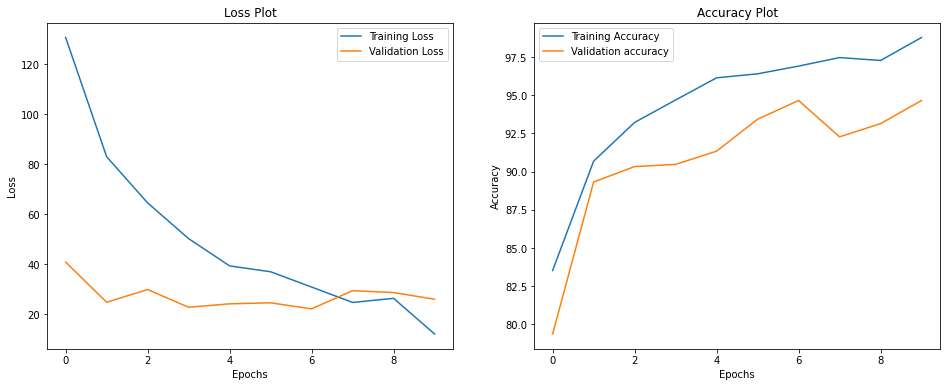

In [ ]:
model,train_loss,train_accuracy,valid_loss,valid_accuracy = training(model,train_loader,valid_loader,train_df,validation_df,model_path,epochs,es_patience,criterion,optimizer,scheduler,best_score)
accuracy_plots(train_loss,train_accuracy,valid_loss,valid_accuracy)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Test Accuracy: 94.07942238267148
Test AUC Score: 0.808


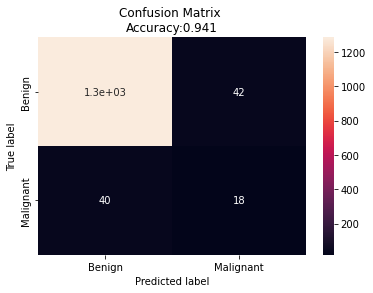

In [ ]:
test_pred_torch,test_accuracy = test_statistics(model,model_path,device,test_loader,test_df)
get_confusion_matrix(test_df,test_pred_torch,test_accuracy)

In [ ]:
test = test_df['target']
pred = torch.round(test_pred_torch)
print(classification_report(test,pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1327
           1       0.30      0.31      0.31        58

    accuracy                           0.94      1385
   macro avg       0.63      0.64      0.64      1385
weighted avg       0.94      0.94      0.94      1385



### Custom Network

In [ ]:
model = Net()  
model = model.to(device)

In [ ]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
training_dataset = MelanomaDataset(df = train_df,
                                 img_dir = train_img_dir, 
                                 train = True,
                                 transforms = get_transforms(mean,std,train=True))

validation_dataset = MelanomaDataset(df = validation_df,
                                   img_dir = train_img_dir, 
                                   train = True,
                                   transforms = get_transforms(mean,std,val=True))

test_dataset = MelanomaDataset(df = test_df,
                                   img_dir = train_img_dir, 
                                   train = True,
                                   transforms = get_transforms(mean,std,test=True))

In [ ]:
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=32,sampler = weighted_sampler, num_workers=4, shuffle=False)
valid_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=16, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle = False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Empty variable to be stored with best validation accuracy
best_score = 0
# Path and filename to save model to
model_path = f'melanoma_{best_score}.pth'  
# Number of Epochs
epochs = 20
# Early stopping if no change in accuracy
es_patience = 5
# Loss Function
criterion = nn.BCEWithLogitsLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0005) 
# Scheduler
scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='max', patience=1, verbose=True, factor=0.4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

Epoch: 1/20..  Training Loss: 0.600..  Training Accuracy: 0.673.. Validation Loss: 0.632..  Validation Accuracy: 0.571 Training Time: 0:01:43
Epoch: 2/20..  Training Loss: 0.554..  Training Accuracy: 0.712.. Validation Loss: 0.794..  Validation Accuracy: 0.482 Training Time: 0:01:44
Epoch: 3/20..  Training Loss: 0.540..  Training Accuracy: 0.722.. Validation Loss: 0.538..  Validation Accuracy: 0.698 Training Time: 0:01:46
Epoch: 4/20..  Training Loss: 0.522..  Training Accuracy: 0.733.. Validation Loss: 0.518..  Validation Accuracy: 0.725 Training Time: 0:01:43
Epoch: 5/20..  Training Loss: 0.507..  Training Accuracy: 0.743.. Validation Loss: 0.499..  Validation Accuracy: 0.667 Training Time: 0:01:43
Epoch: 6/20..  Training Loss: 0.495..  Training Accuracy: 0.750.. Validation Loss: 0.507..  Validation Accuracy: 0.686 Training Time: 0:01:43
Epoch     6: reducing learning rate of group 0 to 2.0000e-04.
Epoch: 7/20..  Training Loss: 0.474..  Training Accuracy: 0.763.. Validation Loss: 0.4

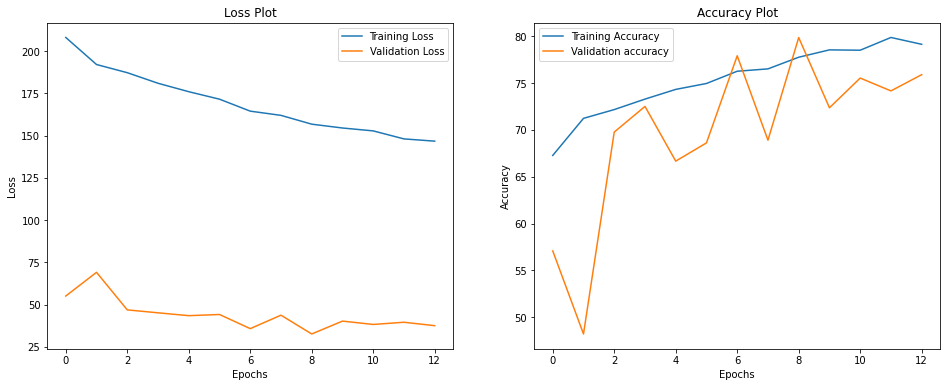

In [ ]:
model,train_loss,train_accuracy,valid_loss,valid_accuracy = training(model,train_loader,valid_loader,train_df,validation_df,model_path,epochs,es_patience,criterion,optimizer,scheduler,best_score)
accuracy_plots(train_loss,train_accuracy,valid_loss,valid_accuracy)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Test Accuracy: 79.63898916967509
Test AUC Score: 0.828


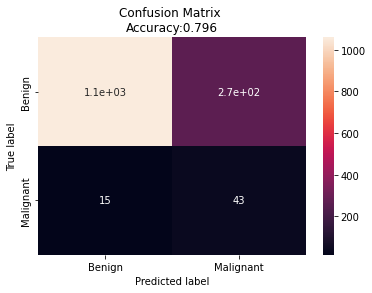

In [ ]:
test_pred_torch,test_accuracy = test_statistics(model,model_path,device,test_loader,test_df)
get_confusion_matrix(test_df,test_pred_torch,test_accuracy)

In [ ]:
test = test_df['target']
pred = torch.round(test_pred_torch)
print(classification_report(test,pred))

              precision    recall  f1-score   support

           0       0.99      0.80      0.88      1327
           1       0.14      0.74      0.23        58

    accuracy                           0.80      1385
   macro avg       0.56      0.77      0.56      1385
weighted avg       0.95      0.80      0.86      1385



# Oversampling the Minority Class
Here we use another dataset where we have more images in the minor class. These images are added from external sources from the web. The image size in this dataset is also 256x256 as our previous dataset.

In [ ]:
df = pd.read_csv('/content/archive-3/train_concat.csv')
train_img_dir = '/content/archive-3/train/train/'

In [ ]:
intermediate_size=0.20
test_size = 0.50

train, interim = train_test_split(df, stratify=df.target, test_size = intermediate_size, random_state=42)
test, valid = train_test_split(interim, stratify=interim.target, test_size = test_size, random_state=42)

train_df=pd.DataFrame(train)
validation_df=pd.DataFrame(valid)
test_df = pd.DataFrame(test)

In [ ]:
print(len(train_df))
print(len(validation_df))
print(len(test_df))
print(train_df.target.value_counts())
print(validation_df.target.value_counts())
print(test_df.target.value_counts())

30118
3765
3765
0    26033
1     4085
Name: target, dtype: int64
0    3255
1     510
Name: target, dtype: int64
0    3254
1     511
Name: target, dtype: int64


In [ ]:
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
training_dataset = MelanomaDataset(df = train_df,
                                 img_dir = train_img_dir, 
                                 train = True,
                                 transforms = get_transforms(mean,std,train=True))

validation_dataset = MelanomaDataset(df = validation_df,
                                   img_dir = train_img_dir, 
                                   train = True,
                                   transforms = get_transforms(mean,std,val=True))

test_dataset = MelanomaDataset(df = test_df,
                                   img_dir = train_img_dir, 
                                   train = True,
                                   transforms = get_transforms(mean,std,test=True))

In [ ]:
class_weights = [1/train_df.target.value_counts()[0],1/train_df.target.value_counts()[1]]
sample_weights = [0]*len(training_dataset)
for idx, (data,label) in enumerate(training_dataset):
    class_weight = class_weights[int(label)]
    sample_weights[idx] = class_weight
weighted_sampler = WeightedRandomSampler(
    sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


### Custom Network

In [ ]:
model = Net()  
model = model.to(device)

In [ ]:
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=32,sampler = weighted_sampler, num_workers=4, shuffle=False)
valid_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=16, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle = False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Empty variable to be stored with best validation accuracy
best_score = 0
# Path and filename to save model to
model_path = f'melanoma_{best_score}.pth'  
# Number of Epochs
epochs = 10
# Early stopping if no change in accuracy
es_patience = 5
# Loss Function
criterion = nn.BCEWithLogitsLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0005) 
# Scheduler
scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='max', patience=1, verbose=True, factor=0.4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

Epoch: 1/10..  Training Loss: 0.333..  Training Accuracy: 0.854.. Validation Loss: 0.195..  Validation Accuracy: 0.932 Training Time: 0:04:59
Epoch: 2/10..  Training Loss: 0.274..  Training Accuracy: 0.885.. Validation Loss: 0.277..  Validation Accuracy: 0.902 Training Time: 0:04:55
Epoch: 3/10..  Training Loss: 0.261..  Training Accuracy: 0.889.. Validation Loss: 0.181..  Validation Accuracy: 0.940 Training Time: 0:04:58
Epoch: 4/10..  Training Loss: 0.249..  Training Accuracy: 0.897.. Validation Loss: 0.217..  Validation Accuracy: 0.920 Training Time: 0:04:57
Epoch: 5/10..  Training Loss: 0.245..  Training Accuracy: 0.897.. Validation Loss: 0.234..  Validation Accuracy: 0.906 Training Time: 0:04:59
Epoch     5: reducing learning rate of group 0 to 2.0000e-04.
Epoch: 6/10..  Training Loss: 0.219..  Training Accuracy: 0.909.. Validation Loss: 0.204..  Validation Accuracy: 0.917 Training Time: 0:04:57
Epoch: 7/10..  Training Loss: 0.214..  Training Accuracy: 0.913.. Validation Loss: 0.2

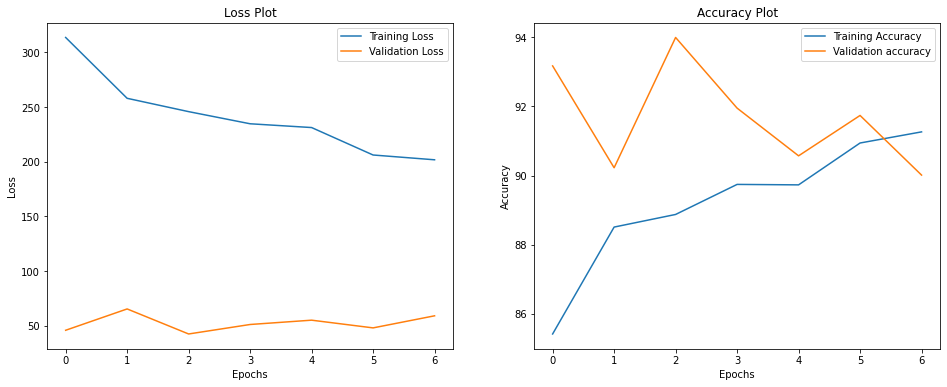

In [ ]:
model,train_loss,train_accuracy,valid_loss,valid_accuracy = training(model,train_loader,valid_loader,train_df,validation_df,model_path,epochs,es_patience,criterion,optimizer,scheduler,best_score)
accuracy_plots(train_loss,train_accuracy,valid_loss,valid_accuracy)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Test Accuracy: 94.20982735723771
Test AUC Score: 0.964


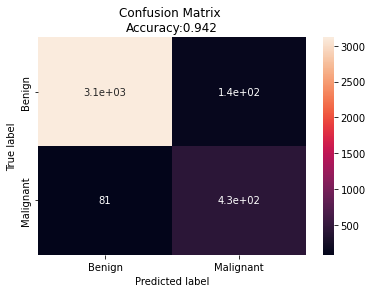

In [ ]:
test_pred_torch,test_accuracy = test_statistics(model,model_path,device,test_loader,test_df)
get_confusion_matrix(test_df,test_pred_torch,test_accuracy)

In [ ]:
test = test_df['target']
pred = torch.round(test_pred_torch)
print(classification_report(test,pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      3254
           1       0.76      0.84      0.80       511

    accuracy                           0.94      3765
   macro avg       0.87      0.90      0.88      3765
weighted avg       0.95      0.94      0.94      3765



### EfficientNet-B2

In [ ]:
arch = EfficientNet.from_pretrained('efficientnet-b2')
model = TransferNet(architecture=arch)  
model = model.to(device)

Loaded pretrained weights for efficientnet-b2


In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
training_dataset = MelanomaDataset(df = train_df,
                                 img_dir = train_img_dir, 
                                 train = True,
                                 transforms = get_transforms(mean,std,train=True))

validation_dataset = MelanomaDataset(df = validation_df,
                                   img_dir = train_img_dir, 
                                   train = True,
                                   transforms = get_transforms(mean,std,val=True))

test_dataset = MelanomaDataset(df = test_df,
                                   img_dir = train_img_dir, 
                                   train = True,
                                   transforms = get_transforms(mean,std,test=True))

In [ ]:
train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=32,sampler = weighted_sampler, num_workers=4, shuffle=False)
valid_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=16, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle = False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Empty variable to be stored with best validation accuracy
best_score = 0
# Path and filename to save model to
model_path = f'melanoma_{best_score}.pth'  
# Number of Epochs
epochs = 5
# Early stopping if no change in accuracy
es_patience = 3
# Loss Function
criterion = nn.BCEWithLogitsLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0006) 
# Scheduler
scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='max', patience=1, verbose=True, factor=0.4)

In [ ]:
model,train_loss,train_accuracy,valid_loss,valid_accuracy = training(model,train_loader,valid_loader,train_df,validation_df,model_path,epochs,es_patience,criterion,optimizer,scheduler,best_score)
accuracy_plots(train_loss,train_accuracy,valid_loss,valid_accuracy)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

Epoch: 1/5..  Training Loss: 0.189..  Training Accuracy: 0.924.. Validation Loss: 0.149..  Validation Accuracy: 0.955 Training Time: 0:15:36
Epoch: 2/5..  Training Loss: 0.139..  Training Accuracy: 0.944.. Validation Loss: 0.102..  Validation Accuracy: 0.964 Training Time: 0:15:36


### The Colab limit reached at this point. We ran the this last model in a separate file and we have published the results in the main report.

In [ ]:
test_pred_torch,test_accuracy = test_statistics(model,model_path,device,test_loader,test_df)
get_confusion_matrix(test_df,test_pred_torch,test_accuracy)

In [ ]:
test = test_df['target']
pred = torch.round(test_pred_torch)
print(classification_report(test,pred))